# *Chapter 8 - Dimensionality Reduction*

In [1]:
import sklearn

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

## Principle Components

In [5]:
import numpy as np

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [6]:
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)

assert np.allclose(X_centered, U @ Σ @ Vt)

## Projecting Down to Dimensions

In [7]:
W2 = Vt[:2].T
X2D = X_centered @ W2

## Using Sklearn

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [10]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [11]:
1 - pca.explained_variance_ratio_.sum()

np.float64(0.09028309326742034)

## Choosing the Right Number of Dimensions

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [13]:
d

np.int64(154)

In [14]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

np.int64(154)

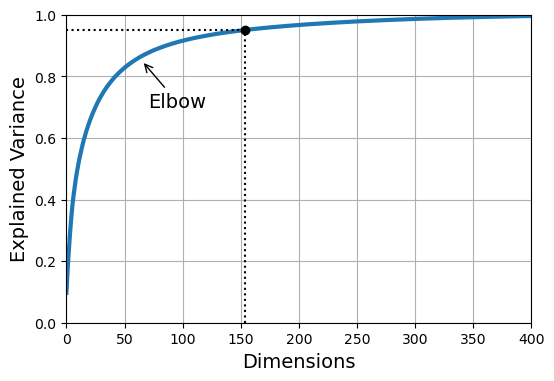

In [17]:
# extra code – this cell generates and saves Figure 8–8

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)

rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [19]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


## PCA for compression

In [20]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [21]:
X_recovered = pca.inverse_transform(X_reduced)

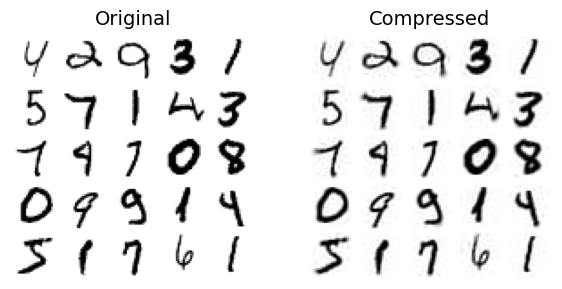

In [23]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")


## Randomized PCA

In [24]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [25]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [26]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

In [27]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

## LLE: Locally linear Embedding

In [28]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)